<a href="https://colab.research.google.com/github/shuaigezhu/starDist/blob/master/GaiaData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from math import pi
from random import randint
from torch import nn
from torch.distributions.kl import kl_divergence
from sklearn import preprocessing
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import glob

Using TensorFlow backend.


### **Normalizaton**

In [0]:
def Normalization(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n

### **MLP**

In [0]:
def batch_mlp(input, output_sizes, variable_scope):
  """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).
  
  Args:
    input: input tensor of shape [B,n,d_in].
    output_sizes: An iterable containing the output sizes of the MLP as defined 
        in `basic.Linear`.
    variable_scope: String giving the name of the variable scope. If this is set
        to be the same as a previously defined MLP, then the weights are reused.
    
  Returns:
    tensor of shape [B,n,d_out] where d_out=output_sizes[-1]
  """
  # Get the shapes of the input and reshape to parallelise across observations
  batch_size, _, filter_size = input.shape.as_list()
  output = tf.reshape(input, (-1, filter_size))
  output.set_shape((None, filter_size))

  # Pass through MLP
  with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
    for i, size in enumerate(output_sizes[:-1]):
      output = tf.nn.relu(
          tf.layers.dense(output, size, name="layer_{}".format(i)))

    # Last layer without a ReLu
    output = tf.layers.dense(
        output, output_sizes[-1], name="layer_{}".format(i + 1))

  # Bring back into original shape
  output = tf.reshape(output, (batch_size, -1, output_sizes[-1]))
  return output

### **Deterministic Encoder**

In [0]:
class DeterministicEncoder(object):
  """The Deterministic Encoder."""

  def __init__(self, output_sizes, attention):
    """(A)NP deterministic encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      attention: The attention module.
    """
    self._output_sizes = output_sizes
    self._attention = attention

  def __call__(self, context_x, context_y, target_x):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.
      target_x: Tensor of shape [B,target_observations,d_x]. 
          For this 1D regression task this corresponds to the x-values.

    Returns:
      The encoded representation. Tensor of shape [B,target_observations,d]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, 
                       "deterministic_encoder")

    # Apply attention
    with tf.variable_scope("deterministic_encoder", reuse=tf.AUTO_REUSE):
        hidden = self._attention(context_x, target_x, hidden)

    return hidden

### **Latent Encoder**

In [0]:
class LatentEncoder(object):
  """The Latent Encoder."""

  def __init__(self, output_sizes, num_latents):
    """(A)NP latent encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._output_sizes = output_sizes
    self._num_latents = num_latents

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([x, y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, "latent_encoder")
      
    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2, 
                          name="penultimate_layer"))
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.layers.dense(hidden, self._num_latents, name="mean_layer")
      log_sigma = tf.layers.dense(hidden, self._num_latents, name="std_layer")
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)

### **Decoder**

In [0]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    hidden = tf.concat([representation, target_x], axis=-1)
    
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

### **Model**

In [0]:
class LatentModel(object):
  """The (A)NP model."""

  def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
    """Initialises the model.

    Args:
      latent_encoder_output_sizes: An iterable containing the sizes of hidden 
          layers of the latent encoder.
      num_latents: The latent dimensionality.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to d_y * 2
          (it encodes both mean and variance concatenated)
      use_deterministic_path: a boolean that indicates whether the deterministic
          encoder is used or not.
      deterministic_encoder_output_sizes: An iterable containing the sizes of 
          hidden layers of the deterministic encoder. The last one is the size 
          of the deterministic representation r.
      attention: The attention module used in the deterministic encoder.
          Only relevant when use_deterministic_path=True.
    """
    self._latent_encoder = LatentEncoder(latent_encoder_output_sizes, 
                                         num_latents)
    self._decoder = Decoder(decoder_output_sizes)
    self._use_deterministic_path = use_deterministic_path
    if use_deterministic_path:
      self._deterministic_encoder = DeterministicEncoder(
          deterministic_encoder_output_sizes, attention)
    

  def __call__(self, query, num_targets, target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Tensor of shape [B,num_contexts,d_x]. 
              Contains the x values of the context points.
          context_y: Tensor of shape [B,num_contexts,d_y]. 
              Contains the y values of the context points.
          target_x: Tensor of shape [B,num_targets,d_x]. 
              Contains the x values of the target points.
      num_targets: Number of target points.
      target_y: The ground truth y values of the target y. 
          Tensor of shape [B,num_targets,d_y].

    Returns:
      log_p: The log_probability of the target_y given the predicted
          distribution. Tensor of shape [B,num_targets].
      mu: The mean of the predicted distribution. 
          Tensor of shape [B,num_targets,d_y].
      sigma: The variance of the predicted distribution.
          Tensor of shape [B,num_targets,d_y].
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    prior = self._latent_encoder(context_x, context_y)
    
    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    if target_y is None:
      latent_rep = prior.sample()
    # For testing, when target_y unavailable, use contexts for latent encoder.
    else:
      posterior = self._latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()
    latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                         [1, num_targets, 1])
    if self._use_deterministic_path:
      deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                      target_x)
      representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
    else:
      representation = latent_rep
      
    dist, mu, sigma = self._decoder(representation, target_x)
    
    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      posterior = self._latent_encoder(target_x, target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
    else:
      log_p = None
      kl = None
      loss = None

    return mu, sigma, log_p, kl, loss

### **Attention**

In [0]:
def uniform_attention(q, v):
  """Uniform attention. Equivalent to np.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  total_points = tf.shape(q)[1]
  rep = tf.reduce_mean(v, axis=1, keepdims=True)  # [B,1,d_v]
  rep = tf.tile(rep, [1, total_points, 1])
  return rep

def laplace_attention(q, k, v, scale, normalise):
  """Computes laplace exponential attention.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    scale: float that scales the L1 distance.
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  k = tf.expand_dims(k, axis=1)  # [B,1,n,d_k]
  q = tf.expand_dims(q, axis=2)  # [B,m,1,d_k]
  unnorm_weights = - tf.abs((k - q) / scale)  # [B,m,n,d_k]
  unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = lambda x: 1 + tf.tanh(x)
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def dot_product_attention(q, k, v, normalise):
  """Computes dot product attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = tf.shape(q)[-1]
  scale = tf.sqrt(tf.cast(d_k, tf.float32))
  unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = tf.sigmoid
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def multihead_attention(q, k, v, num_heads=8):
  """Computes multi-head attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    num_heads: number of heads. Should divide d_v.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = q.get_shape().as_list()[-1]
  d_v = v.get_shape().as_list()[-1]
  head_size = d_v / num_heads
  key_initializer = tf.random_normal_initializer(stddev=d_k**-0.5)
  value_initializer = tf.random_normal_initializer(stddev=d_v**-0.5)
  rep = tf.constant(0.0)
  for h in range(num_heads):
    o = dot_product_attention(
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wq%d' % h, use_bias=False, padding='VALID')(q),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wk%d' % h, use_bias=False, padding='VALID')(k),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wv%d' % h, use_bias=False, padding='VALID')(v),
        normalise=True)
    rep += tf.layers.Conv1D(d_v, 1, kernel_initializer=value_initializer,
                      name='wo%d' % h, use_bias=False, padding='VALID')(o)
  return rep

class Attention(object):
  """The Attention module."""

  def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True,
               num_heads=8):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention. 
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalise: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self._rep = rep
    self._output_sizes = output_sizes
    self._type = att_type
    self._scale = scale
    self._normalise = normalise
    if self._type == 'multihead':
      self._num_heads = num_heads

  def __call__(self, x1, x2, r):
    """Apply attention to create aggregated representation of r.

    Args:
      x1: tensor of shape [B,n1,d_x].
      x2: tensor of shape [B,n2,d_x].
      r: tensor of shape [B,n1,d].
      
    Returns:
      tensor of shape [B,n2,d]

    Raises:
      NameError: The argument for rep/type was invalid.
    """
    if self._rep == 'identity':
      k, q = (x1, x2)
    elif self._rep == 'mlp':
      # Pass through MLP
      k = batch_mlp(x1, self._output_sizes, "attention")
      q = batch_mlp(x2, self._output_sizes, "attention")
    else:
      raise NameError("'rep' not among ['identity','mlp']")

    if self._type == 'uniform':
      rep = uniform_attention(q, r)
    elif self._type == 'laplace':
      rep = laplace_attention(q, k, r, self._scale, self._normalise)
    elif self._type == 'dot_product':
      rep = dot_product_attention(q, k, r, self._normalise)
    elif self._type == 'multihead':
      rep = multihead_attention(q, k, r, self._num_heads)
    else:
      raise NameError(("'att_type' not among ['uniform','laplace','dot_product'"
                       ",'multihead']"))

    return rep

### **Data wrapper**

In [0]:
def datawrap(data_x, data_y, batch_size):
  num_target = 50
  num_context = 50
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=True)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)[:,:num_context+num_target,:]
  target_y = np.array(batch_datay)[:,:num_context+num_target,:]
  
    #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = num_context+num_target
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

def testdatawrap(data_x, data_y, batch_size):
  num_target = 50
  num_context = 50
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=True)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]#context is belong to target
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)#x values
  target_y = np.array(batch_datay)#y values
  
  #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = batch_size 
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

### **Data selector**

In [0]:
# input your filename (csv.)
filename = "/content/all_gaia_yufengzhu.csv"

# all the features
# solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,
# parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,
# ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,
# parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,
# astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,
# astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,
# astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,
# visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,
# phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,
# phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,
# phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,
# phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,
# rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,
# ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,
# a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,
# flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper

df = pd.read_csv(filename)

In [11]:
def selected_features (dataf, selectedf):
  dataf = dataf.loc[:, selectedf]
  return dataf

# selected features
selectedf = ['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'phot_g_mean_flux',
                    'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
                     'phot_rp_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp']
gaia_df = selected_features(df, selectedf)
gaia_df.head()

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp
0,2449588108548044544,1.200590,0.336011,-1.101586,0.223228,0.148108,0.494231,451.860581,0.949830,268.504574,5.259502,299.713478,4.616114,19.050854,19.279009,18.570154,0.708855,0.228155,0.480700
1,2449591613241290624,1.010105,0.125334,-1.208384,0.080224,4.946350,0.176183,1795.014675,1.388877,373.834306,5.657353,2229.174080,5.786035,17.553196,18.919691,16.391560,2.528131,1.366495,1.161636
2,2449593021990602240,0.957800,0.265494,-1.147778,0.175054,2.377225,0.385595,556.364008,1.007956,110.273241,6.022923,733.751687,5.347473,18.824968,20.245213,17.598047,2.647165,1.420244,1.226921
3,2449595500187839360,0.901956,0.076135,-1.162254,0.048287,0.674556,0.106873,4121.808408,2.305190,1998.096403,8.629083,3059.473520,10.178913,16.650646,17.099848,16.047804,1.052044,0.449202,0.602842
4,2449586871597425152,1.223193,0.295541,-1.162055,0.176805,0.872118,0.405423,594.974435,1.086138,294.199064,7.992073,486.763098,5.330821,18.752119,19.179785,18.043627,1.136158,0.427666,0.708492


In [145]:
#select parallax between 1 - 1.5 
gaia_selected = gaia_df.loc[(df['parallax'] >= 1) & (df['parallax'] <= 10) & (df['parallax_error'] >= 0) & (df['parallax_error'] <= 0.5)]
gaia_selected.shape

(98658, 19)

### **Visualization**

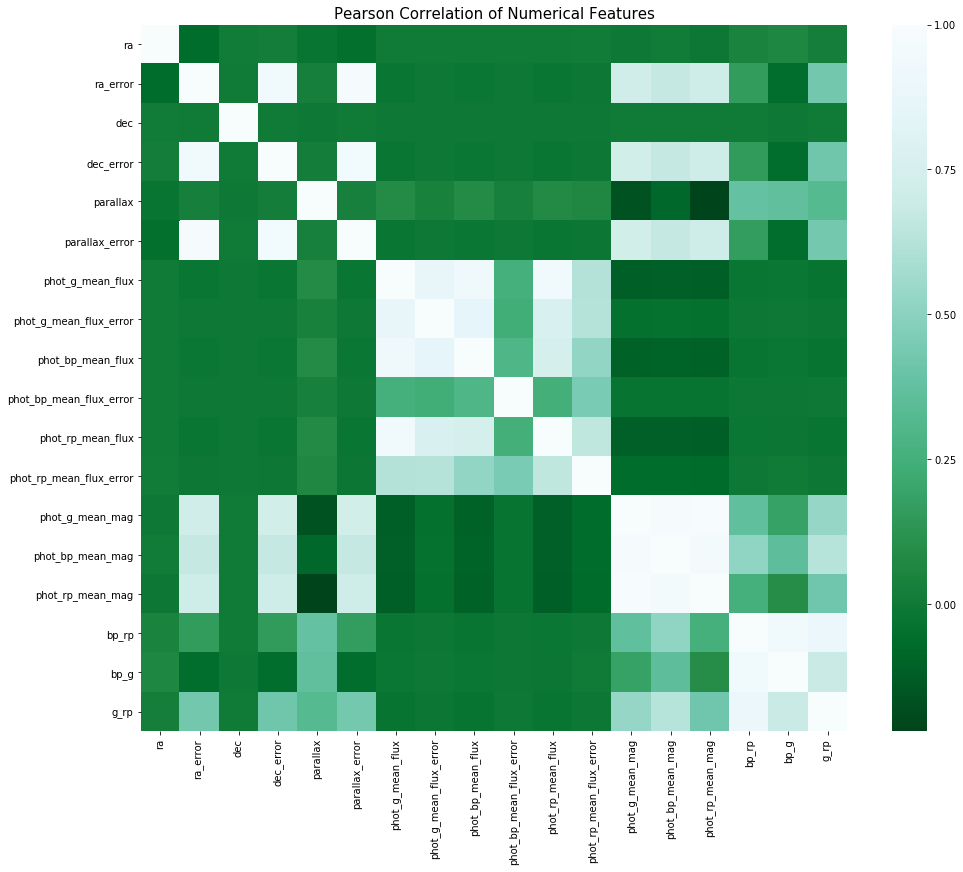

In [152]:
#Pearson Hotmap
import matplotlib.pyplot as plt
import seaborn as sns

features_numerical = ['ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'phot_g_mean_flux',
                    'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
                     'phot_rp_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','bp_g','g_rp']
gaia_df[features_numerical].head()
plt.subplots(figsize=(16, 13))
sns.heatmap(gaia_df[features_numerical].corr(), vmax=1.0, square=True, cmap="BuGn_r")
plt.title("Pearson Correlation of Numerical Features", fontsize=15)
plt.show()

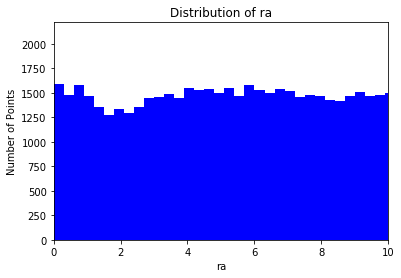

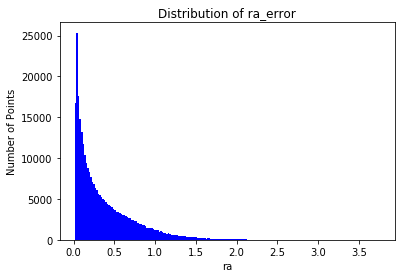

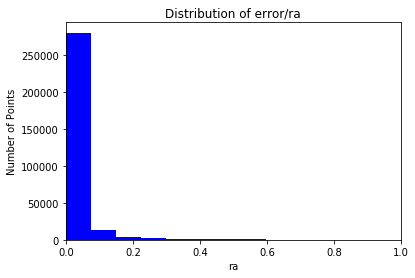

In [98]:
#distributin of ra
#num_bins = 20000
#n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=0.5)
#plt.xlim(-2, 2)
#plt.show()
np_ra = np.array(gaia_df.loc[:,['ra']])
num_bins = 200
n, bins, patches = plt.hist(np_ra, num_bins, facecolor='blue', alpha=1)
plt.xlabel('ra')
plt.ylabel('Number of Points')
plt.title(r'Distribution of ra')
plt.xlim(0, 10)
#plt.xlim(-2, 2)
plt.show()

#distribution of ra error
np_ra_error = np.array(gaia_df.loc[:,['ra_error']])
num_bins = 200
n, bins, patches = plt.hist(np_ra_error, num_bins, facecolor='blue', alpha=1)
plt.xlabel('ra')
plt.ylabel('Number of Points')
plt.title(r'Distribution of ra_error')
#plt.xlim(-2, 2)
plt.show()

#distribution of ra_error/ra

num_bins = 20000
n, bins, patches = plt.hist(np_ra_error/np_ra, num_bins, facecolor='blue', alpha=1)
plt.xlabel('ra')
plt.ylabel('Number of Points')
plt.title(r'Distribution of error/ra')
plt.xlim(0, 1)
plt.show()

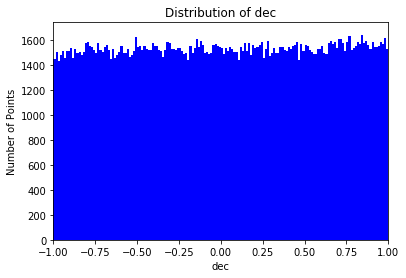

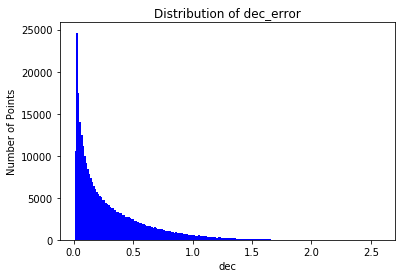

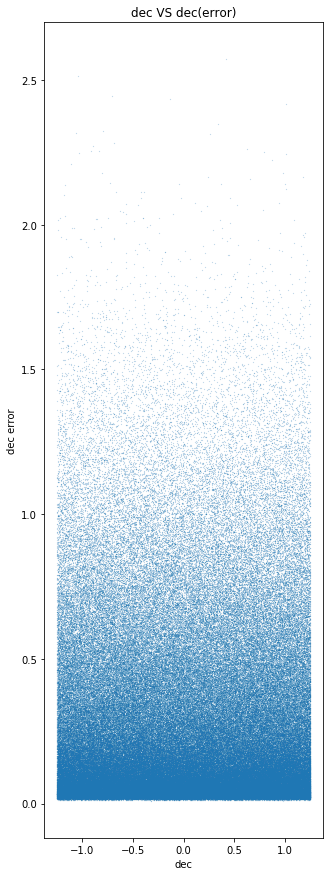

In [105]:
#distributin of dec
#num_bins = 20000
#n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=0.5)
#plt.xlim(-2, 2)
#plt.show()
np_dec = np.array(gaia_df.loc[:,['dec']])
num_bins = 200
n, bins, patches = plt.hist(np_dec, num_bins, facecolor='blue', alpha=1)
plt.xlabel('dec')
plt.ylabel('Number of Points')
plt.title(r'Distribution of dec')
plt.xlim(-1, 1)
#plt.xlim(-2, 2)
plt.show()

#distribution of dec error
np_dec_error = np.array(gaia_df.loc[:,['dec_error']])
num_bins = 200
n, bins, patches = plt.hist(np_dec_error, num_bins, facecolor='blue', alpha=1)
plt.xlabel('dec')
plt.ylabel('Number of Points')
plt.title(r'Distribution of dec_error')
#plt.xlim(-2, 2)
plt.show()

#distribution of dec_error/dec

np_dec_error = np.array(gaia_df.loc[:,['dec_error']])
np_dec= np.array(gaia_df.loc[:,['dec']])
plt.figure(figsize=(5,15)) 
plt.scatter(np_dec, np_dec_error, s=0.01)
plt.xlabel('dec')
plt.ylabel('dec error')
plt.title(r'dec VS dec(error)')
plt.show()

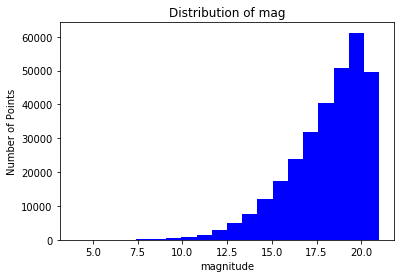

In [107]:
# distribution of 'phot_g_mean_mag'
np_dec = np.array(gaia_df.loc[:,['phot_g_mean_mag']])
num_bins = 20
n, bins, patches = plt.hist(np_dec, num_bins, facecolor='blue', alpha=1)
plt.xlabel('magnitude')
plt.ylabel('Number of Points')
plt.title(r'Distribution of mag')
#plt.xlim(-1, 1)

plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


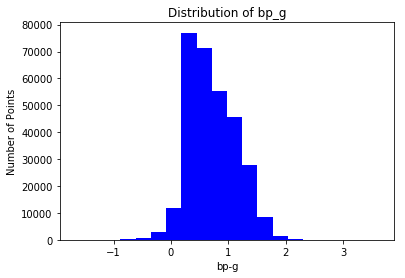

In [112]:
# Distribution of bp-g
np_bp_g = np.array(gaia_df.loc[:,['bp_g']])
num_bins = 20
n, bins, patches = plt.hist(np_bp_g, num_bins, facecolor='blue', alpha=1)
plt.xlabel('bp-g')
plt.ylabel('Number of Points')
plt.title(r'Distribution of bp_g')
#plt.xlim(-1, 1)

plt.show()


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


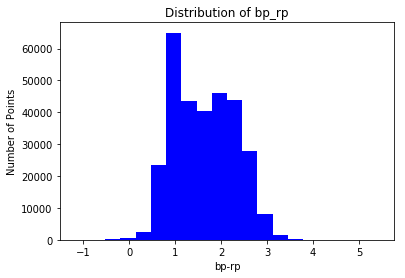

In [114]:
# Distribution of bp_rp
np_bp_rp = np.array(gaia_df.loc[:,['bp_rp']])
num_bins = 20
n, bins, patches = plt.hist(np_bp_rp, num_bins, facecolor='blue', alpha=1)
plt.xlabel('bp-rp')
plt.ylabel('Number of Points')
plt.title(r'Distribution of bp_rp')
#plt.xlim(-1, 1)

plt.show()

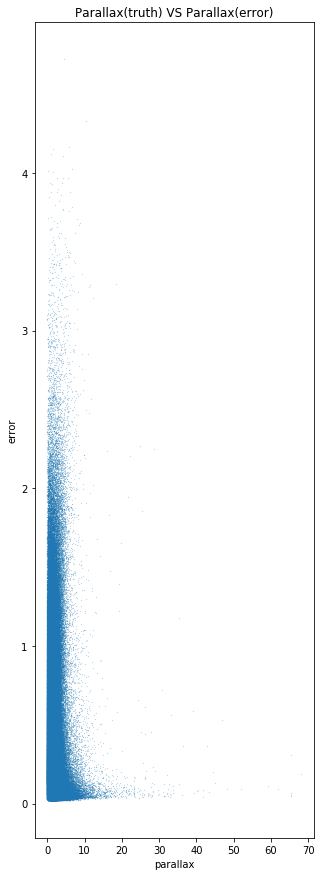

In [44]:
#relation between parallax(error) and parallax
np_parallax = np.array(gaia_df.loc[:,['parallax']])
np_parallax_error = np.array(gaia_df.loc[:,['parallax_error']])
plt.figure(figsize=(5,15)) 
plt.scatter(np_parallax, np_parallax_error, s=0.01)
plt.xlabel('parallax')
plt.ylabel('error')
plt.title(r'Parallax(truth) VS Parallax(error)')
plt.show()

### **Data processsing**

In [0]:
#select g, bp-g, bp-rp
new_df = gaia_selected.loc[:, ['ra', 'dec','phot_g_mean_mag', 'bp_g', 'bp_rp', 'parallax']]
new_df = new_df.dropna() #drop rows with nah

x_df = new_df.loc[:,['ra', 'dec','phot_g_mean_mag', 'bp_g', 'bp_rp']]
y_df = new_df.loc[:,['parallax']]

#split into train and validation
ratio = 0.95 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

train_x = np.array(train_x).astype(float)
train_y = np.array(train_y).astype(float)
test_x = np.array(test_x).astype(float)
test_y = np.array(test_y).astype(float)

locations = np.random.choice(train_x.shape[0],
                                 size=20000,
                                 replace=False)

#r_scaler = preprocessing.RobustScaler()
train_norm_x = Normalization(train_x)[locations,:]
#train_norm_x = Normalization(train_x)
train_norm_y = Normalization(train_y)[locations,:]
#train_norm_y = Normalization(train_y)
#train_norm_y = r_scaler.fit_transform(train_y)
test_norm_x = Normalization(test_x)
test_norm_y = Normalization(test_y)
#test_norm_y = r_scaler.fit_transform(test_y)


### **Main**

In [147]:
TRAINING_ITERATIONS = 10000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 200 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define data
batch_size = 100
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)

test_query, test_target_y, test_num_total_points, test_num_context_points = testdatawrap(test_norm_x, test_norm_y, test_norm_x.shape[0])

# Define the loss
_, _, log_prob, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)

# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _ = model(test_query, test_num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-3)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()

# Train and plot
with tf.train.MonitoredSession() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, std_y, target_y, whole_query = sess.run(
          [loss, mu, sigma, test_target_y, 
           test_query])
      print("The accuracy is .....")
      accuracy = abs(pred_y-target_y)/target_y
      accuracy = np.reshape(accuracy, accuracy.shape[1])
      print(np.mean(accuracy))
      
      print("The prediction is ....")
      print(pred_y[:,:5,:])
      print("The label is ....")
      print(target_y[:,:5,:])
      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      #plot_functions(target_x, target_y, context_x, context_y, pred_y, std_y)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The accuracy is .....
0.005677907
The prediction is ....
[[[ 0.04924511]
  [-0.04184545]
  [ 0.00314603]
  [ 0.06035852]
  [ 0.11706263]]]
The label is ....
[[[-0.055447  ]
  [ 0.03339759]
  [-0.03141342]
  [-0.08372118]
  [-0.14549191]]]
Iteration: 0, loss: 0.45991045236587524
The accuracy is .....
1.0230454
The prediction is ....
[[[-0.04920779]
  [ 0.04068737]
  [-0.01440351]
  [-0.12307151]
  [-0.04576354]]]
The label is ....
[[[-0.055447  ]
  [ 0.03339759]
  [-0.03141342]
  [-0.08372118]
  [-0.14549191]]]
Iteration: 200, loss: -1.0210223197937012
The accuracy is .....
0.8548384
The prediction is ....
[[[ 0.00350489]
  [ 0.03805802]
  [-0.05643657]
  [-0.1351705 ]
  [-0.06389638]]]
The label is ....
[[[-0.055447  ]
  [ 0.03339759]
  [-0.03141342]
  [-0.08372118]
  [-0.14549191]]]
Iteration: 400, loss: -1.0708638429641724
The accuracy is .....
0.7391899
The predict

KeyboardInterrupt: ignored

## **Evaluation**

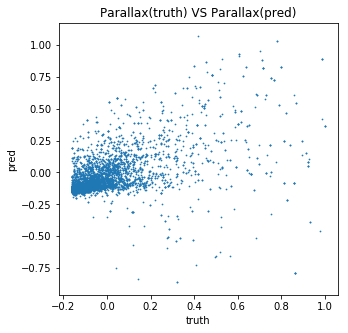

In [148]:


plt.figure(figsize=(5,5)) 
plt.scatter(target_y, pred_y, s=0.5)
plt.xlabel('truth')
plt.ylabel('pred')
plt.title(r'Parallax(truth) VS Parallax(pred)')
plt.show()

In [149]:
acc = abs(pred_y - target_y)/target_y
print(np.median(abs(pred_y - target_y)/target_y))

-0.112290725


In [150]:
print(pred_y)
print(target_y)

[[[ 0.05515524]
  [ 0.05664245]
  [-0.07859118]
  ...
  [-0.09345921]
  [ 0.62596625]
  [ 0.51942533]]]
[[[-0.055447  ]
  [ 0.03339759]
  [-0.03141342]
  ...
  [ 0.0262989 ]
  [ 0.3102548 ]
  [ 0.579187  ]]]


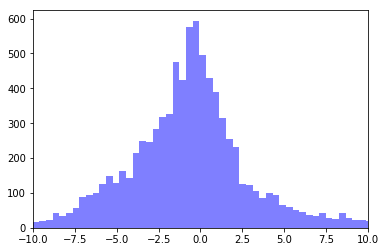

In [84]:
#show the distribution of (pred_y - target_y)/target_y
num_bins = 20000
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=0.5)
plt.xlim(-10, 10)
plt.show()

# **Log**
###(1)
###Select parallax between 0 and 4
###select parallax error between 0 and 0.5
###total points: 192289
###train with 50000 points
###lr: 1e-3
###result: failed (the size of data does not make sense)

###(2)
###Select parallax between 3 and 4
###select parallax error between 0 and 0.5
###total points: 8925
###lr: 1e-3, 1e-4
###train with 8400 points
###result: failed

###(3)
###Select parallax between 1 and 4
###select parallax error between 0 and 0.5
###total points: 89250
###lr: 1e-3, 1e-4
###train with 20000 points
###result: failed

###(4)
###Select parallax between 0 and 0.5
###select parallax error between 0 and 0.5
###total points: 48127
###lr: 1e-3, 1e-4
###train with 20000 points
###result: failed

###(5)
###Select parallax between 1 and 1.5
###select parallax error between 0 and 0.5
###total points: 34760
###lr: 1e-3, 1e-4
###train with 20000 points
###result: failed